# Explanation

In the past, recoginizing features in images effectively has required the inductive bias of CNNs to pick out higher-level features via kernels. However, due to the scale transformers can achieve, it became feasible to use transformers to learn about images directly without explicitly creating feature maps.

After the initial _Attention Is All You Need_ paper, several attempts were made to make transformers effective at image classification tasks using different arcthiectures.

Some tried passing the image directly to the transformer and allowing it to attend to individual pixels. These approaches were mostly ineffective - there are too many pixel level attention relationships for this strategy to be tractable.

The vision transformer (ViT) instead introduces a new approach to this problem that works effectively

### Intuition

The naive approach of allowing each pixel to attend to every other pixel doesn't work since this would require an exponential number of attention relationships with the dimensions of the image, which get quite large.

The ViT solves this by dividing each image into multiple 2D **image patches**, each with a subset of the pixels in the image.

It then uses projection layers to project these 2D image patches into a patch embedding space (rather than encoding the pixels directly). This embedding space can be thought of as accomplishing something similar to convolutional layers in CNNs (but far more generalized) by capturing some high-level information about the features within the patches.

These embeddings are then fed to the transformer as if they were equivalent to words. They're fed with positional encodings, but these encodings encode their position in the sequence and say nothing about their 2D position in the image.

Beyond this, the ViT behaves exactly the same as the regular transformer. This transformation of images via patches into embeddings enables the standard transformer architecture to perform as well as CNNs on image related tasks without the same inductive bias.

Notably, the ViT architecture is later used in CLIP to enable a joint embedding model conditioned on both images and text.

# My Notes

## 📜 [An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929)

> When trained on mid-sized datasets such as ImageNet without strong regularization, these [transformer] models yield modest accuracies of a few percentage points below ResNets of comparable size

> Transformers lack some of the inductive biases inherent to CNNs, such as translation equivariance and locality, and therefore do not generalize well when trained on insufficient amounts of data.

> However, the picture changes if the models are trained on larger datasets (14M-300M images). We find that large scale training trumps inductive bias.

Another huge statement again showing the scale is all you need. The constraint is really how much is a model architecture conducive to scale (which is constrained by optimization & regularization with large number of parameters, compute, and time to convergence).

The inductive bias of CNNs actually doesn’t get you as far as training transformers on more data.

> Naive application of self-attention to images would require that each pixel attends to every other pixel. With quadratic cost in the number of pixels, this does not scale to realistic input sizes. Thus, to apply Transformers in the context of image processing, several approximations have been tried in the past.

### Method

**1. Vision Transformer**

> In model design we follow the original Transformer as closely as possible. An advantage of this intentionally simple setup is that scalable NLP Transformer architectures – and their efficient implementations – can be used almost out of the box

Don’t reinvent the wheel. Do as little work as possible to verify just your core thesis and not build everything from scratch.

The image is divided into patches of dimension $(P, P)$ where there are $N = HW/P^2$ total patches, which is also the number of inputs to the transformer.

The transformer uses constant latent vector size $D$ for every layer, so we create a projection from the $P^2$ length flattened patches to the size $D$ embedding vector for each patch. This projection is trained with the network.

Positional encodings are also included with each token, although they include no information about the patches 2D position.

**2. Inductive Bias**

> We note that Vision Transformer has much less image-specific inductive bias than CNNs.

Transformers has almost no inductive bias compared with what the CNNs have, but they still perform better. Needing inductive bias is a sign that you haven’t scaled far enough.

### Conclusion

> Unlike prior works using self-attention in computer vision, we do not introduce image-specific inductive biases into the architecture apart from the initial patch extraction step. Instead, we interpret an image as a sequence of patches and process it by a standard Transformer encoder as used in NLP.

> This simple, yet scalable, strategy works surprisingly well when coupled with pre-training on large datasets. Thus, Vision Transformer matches or exceeds the state of the art on many image classification datasets, whilst being relatively cheap to pre-train.

> Finally, further scaling of ViT would likely lead to improved performance.


# Implementation

The implementation here is based on this [visualizing attention mappings in vision transformer](https://www.youtube.com/watch?v=y1ZmMcMYjkY) video - since the vision transformer is being used for classification here which doesn't introduce anything new, we instead focus on visualizing the unique parts of the vision transformer (the patches and image attention).

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm.notebook import tqdm_notebook

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
batch_size = 100
image_size = 28
embed_dim = 256
hidden_dim = embed_dim * 3
num_heads = 8
num_layers = 6
patch_size = 7
num_patches = 16
num_channels = 1
num_classes = 10
dropout = 0.2
learning_rate=3e-4

In [22]:
from torchvision import datasets, transforms

# MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Below is really the main update of the vision transformer (very simple) - they split the image into patches before feeding it into the attention layer.

In [21]:
def image_to_patches(x, patch_size, flatten_channels=True):
    B, C, H, W = x.shape # MNIST [B, 1, 28, 28]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)
    x = x.flatten(1, 2)
    if flatten_channels:
        x = x.flatten(2, 4)
    return x

Now that we've added the function to split the image into patches, we can visualize the patches below.

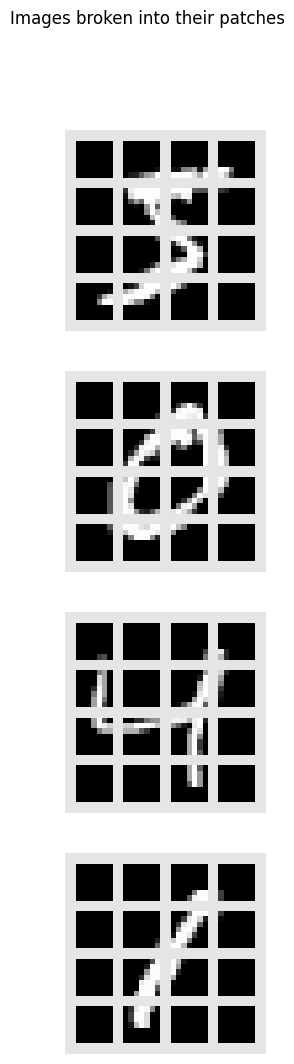

In [27]:
examples = torch.stack([train_dataset[idx][0] for idx in range(4)], dim=0)
patches = image_to_patches(examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images broken into their patches")
for i in range(examples.shape[0]):
    img_grid = torchvision.utils.make_grid(patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [49]:
class Block(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super(Block, self).__init__()

        self.ln1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # normalize inputs before passing on
        x_norm = self.ln1(x)
        # apply multi-headed attention
        x = x + self.attention(x_norm, x_norm, x_norm)[0]
        # apply linear layers after attention
        x = x + self.layers(self.ln2(x))
        return x

In [50]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout
    ):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size

        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(Block(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # the [CLS] token added to each sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        # positional embeddings for each token
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # convert the image into patches first
        x = image_to_patches(x, self.patch_size)     # x.shape ---> batch, num_patches, (patch_size**2)
        B, T, _ = x.shape
        x = self.input_layer(x)                     # x.shape ---> batch, num_patches, embed_dim

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)        # x.shape ---> batch, num_patches+1, embed_dim
        x = x + self.pos_embedding[:, : T + 1]      # x.shape ---> batch, num_patches+1, embed_dim

        # apply transformer layers
        x = self.dropout(x)
        x = x.transpose(0, 1)                       # x.shape ---> num_patches+1, batch, embed_dim
        x = self.transformer(x)                     # x.shape ---> num_patches+1, batch, embed_dim

        # Perform classification prediction on MNIST
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [ ]:
model = VisionTransformer(
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    patch_size=patch_size,
    num_channels=num_channels,
    num_patches=num_patches,
    num_classes=num_classes,
    dropout=dropout
)

model.to(device)

In [52]:
cross_entropy = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(epochs):
    for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
        model.train(True)
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = cross_entropy(preds, labels)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"epoch {epoch + 1}: loss {loss.item()}")



epoch 0:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 1: loss 0.1619037389755249


epoch 1:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 2: loss 0.22406139969825745


epoch 2:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 3: loss 0.13390690088272095


epoch 3:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 4: loss 0.1360750049352646


epoch 4:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 5: loss 0.07399176806211472


epoch 5:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 6: loss 0.0303703211247921


epoch 6:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 7: loss 0.0283915176987648


epoch 7:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 8: loss 0.05242493748664856


epoch 8:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 9: loss 0.009825177490711212


epoch 9:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 10: loss 0.01738058030605316


epoch 10:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 11: loss 0.04222101718187332


epoch 11:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 12: loss 0.051800116896629333


epoch 12:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 13: loss 0.005290600471198559


epoch 13:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 14: loss 0.005740962456911802


epoch 14:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 15: loss 0.03268446400761604


epoch 15:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 16: loss 0.0589708536863327


epoch 16:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 17: loss 0.0074279047548770905


epoch 17:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 18: loss 0.0026569529436528683


epoch 18:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 19: loss 0.010190107859671116


epoch 19:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 20: loss 0.05160503461956978


Now that we have a trained model, we can inspect the parameters of the model to actually visualize attention and see where the model is primarily focused.

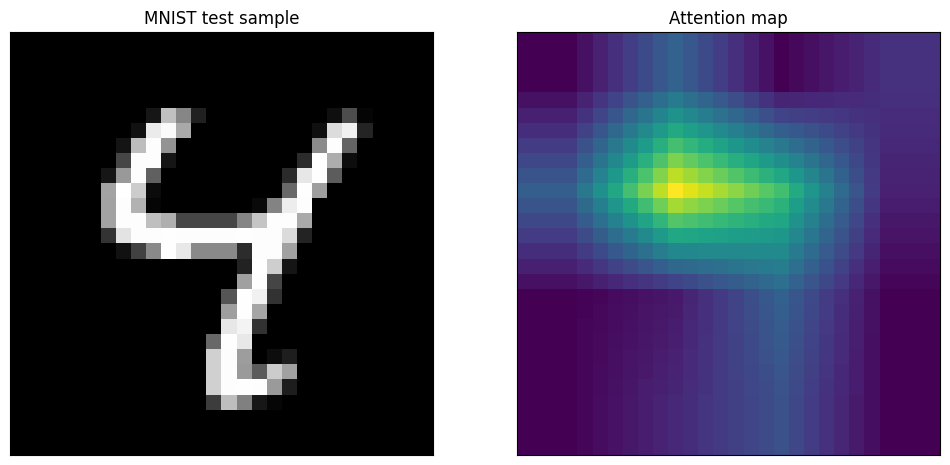

In [64]:
# I cherry picked this one because the 4 attention map is cool
img_tensor = test_dataset.data[6].to(device)

patches = image_to_patches(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
patches = model.input_layer(patches.float())
transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
transformer_input_expanded = model.transformer[0].layers[0](transformer_input)[0]

last_dim = (transformer_input_expanded.shape[0]*transformer_input_expanded.shape[1]) / ((num_patches+1)*3*num_heads)
# Split Q, K, V matrices into mulitple q, k, and v vectors for multi-head attention
qkv = transformer_input_expanded.reshape(num_patches+1, 3, num_heads, int(last_dim))
q = qkv[:, 0].permute(1, 0, 2)
k = qkv[:, 1].permute(1, 0, 2)
kT = k.permute(0, 2, 1)
# Attention matrix
attention_matrix = q @ kT

attention_matrix_mean = torch.mean(attention_matrix, dim=0)
residual_att = torch.eye(attention_matrix_mean.size(1)).to(device)
aug_att_mat = attention_matrix_mean + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

attn_heatmap = joint_attentions[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
img = np.asarray(img_tensor.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('MNIST test sample')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2.imshow(attn_heatmap_resized.detach().cpu().numpy())
ax2.set_title('Attention map')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)